In [76]:
%%capture --no-stderr
%pip install -U langgraph
%pip install openai

In [77]:
import random

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage

# OpenAI chat model
openai_model = ChatOpenAI(model="gpt-4-turbo", temperature=0.7)

# Game State
class State(TypedDict):
    object_to_guess: str
    questions_asked: Annotated[list, add_messages]
    guess_attempts: int
    max_questions: int
    winner: str | None

initial_state: State = {
    "object_to_guess": random.choice(["Elephant", "Laptop", "Saturn", "Eiffel Tower", "Shakespeare"]),
    "questions_asked": [],
    "guess_attempts": 0,
    "max_questions": 5,
    "winner": None,
}

# Bot 1: Asks a question
def ask_question(state: State):
    questions = [item.content for item in state['questions_asked']]
    prompt = f"""You are playing 20 Questions. You need to guess the object that the other AI is thinking of. 
    Based on previous answers: {questions}, ask a strategic yes/no question."""
    
    response = openai_model.invoke([SystemMessage(content=prompt)])
    return {"questions_asked": [response.content]}

# Bot 2: Answers the question
def answer_question(state: State):
    last_question = state["questions_asked"][-1].content
    object_name = state["object_to_guess"].lower()

    # Simple rule-based answering
    if object_name in last_question.lower():
        answer = "Yes"
    elif "is it alive" in last_question.lower() and object_name in ["elephant", "shakespeare"]:
        answer = "Yes"
    elif "is it a planet" in last_question.lower() and object_name == "saturn":
        answer = "Yes"
    elif "is it a building" in last_question.lower() and object_name == "eiffel tower":
        answer = "Yes"
    else:
        answer = random.choice(["Yes", "No", "I don't know"])

    return {"answer": answer}

# Bot 1: Makes a guess after some questions
def make_guess(state: State):
    questions = [item.content for item in state['questions_asked']]
    prompt = f"""You have asked these questions: {questions} 
    and received these answers. Now make a final guess at what the object is."""
    
    response = openai_model.invoke([SystemMessage(content=prompt)])
    guess = response.content
    guess_attempts = state["guess_attempts"] + 1

    if guess.lower() == state["object_to_guess"].lower():
        return {"winner": "Questioner", "guess_attempts": guess_attempts}
    else:
        return {"guess_attempts": guess_attempts}

def check_game_over(state: State):
    return state

# Check if game should continue
def router(state: State):
    if state["winner"]:
        return "end_game"
    elif state["guess_attempts"] >= state["max_questions"]:
        return "end_game"
    return "ask_question"

# End Game Node
def end_game(state: State):
    return {
        "message": f"Game Over! The correct answer was {state['object_to_guess']}. Winner: {state['winner'] if state['winner'] else 'No one'}"
    }

# Create Graph
builder = StateGraph(State)

# Add nodes
builder.add_node("ask_question", ask_question)
builder.add_node("answer_question", answer_question)
builder.add_node("make_guess", make_guess)
builder.add_node("check_game_over", check_game_over)
builder.add_node("end_game", end_game)

# Define flow
builder.set_entry_point("ask_question")
builder.add_edge("ask_question", "answer_question")
builder.add_edge("answer_question", "make_guess")
builder.add_edge("make_guess", "check_game_over")
builder.add_conditional_edges("check_game_over", router, {"ask_question": "ask_question", "end_game": "end_game"})

# Compile and Run
graph = builder.compile()

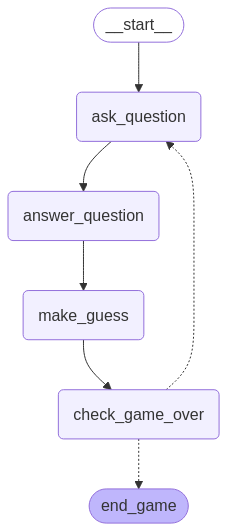

In [78]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [79]:
graph.invoke(initial_state)

{'object_to_guess': 'Eiffel Tower',
 'questions_asked': [HumanMessage(content='Is the object something that is typically found indoors?', additional_kwargs={}, response_metadata={}, id='826cd76d-094e-4728-b46a-dd47b4a00f9f'),
  HumanMessage(content='Is the object commonly used in a household?', additional_kwargs={}, response_metadata={}, id='6bba6ab8-6c65-4000-a87f-b7c46e18a49d'),
  HumanMessage(content='Is the object smaller than a microwave oven?', additional_kwargs={}, response_metadata={}, id='8336bc13-f050-4af5-8d1f-9f86abf42a03'),
  HumanMessage(content='Is the object electronic?', additional_kwargs={}, response_metadata={}, id='3debcb2e-6c94-4104-a51a-793629ffdc18'),
  HumanMessage(content='Is the object used primarily in the kitchen?', additional_kwargs={}, response_metadata={}, id='38e94a38-8cff-43da-845f-b5dcfa87cbd6')],
 'guess_attempts': 5,
 'max_questions': 5,
 'winner': None}